## Part 3 - Supervised Learning: Generalisation & Overfitting; Decision trees.

Importing the required libraries and checking for the python version.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import cv2

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Loading only the training dataset for now :

In [2]:
CW_DATASET_PATH = "CW_dataset"

def load_data(dataset_path=CW_DATASET_PATH):
    x_train_all_path = os.path.join(dataset_path, "x_train_all.csv")
    y_train_all_path = os.path.join(dataset_path, "y_train_all.csv")
    x_test_all_path = os.path.join(dataset_path, "x_test_all.csv")
    y_test_all_path = os.path.join(dataset_path, "y_test_all.csv")

    x_train_all = pd.read_csv(x_train_all_path)
    y_train_all = pd.read_csv(y_train_all_path)
    x_test_all = pd.read_csv(x_test_all_path)
    y_test_all = pd.read_csv(y_test_all_path)

    return x_train_all, y_train_all,x_test_all,y_test_all

In [3]:
x_train, y_train,x_test, y_test = load_data()

In [4]:
x_train.shape

(9690, 2304)

In [5]:
y_train.shape

(9690, 1)

#### 1) Using the Decision Tree (on the training dataset only)

In [6]:
from sklearn.tree import DecisionTreeClassifier

x_train = np.asarray(x_train)
xtrain_images = x_train.reshape(x_train.shape[0], -1)
y_train = np.asarray(y_train).ravel()

dt_train = DecisionTreeClassifier(max_depth=20,random_state=42)
dt_train.fit(xtrain_images, y_train) 

predictions = dt_train.predict(x_train)

[Text(0.3813591231772832, 0.9761904761904762, 'x[1264] <= 84.5\ngini = 0.824\nsamples = 9690\nvalue = [210, 2220, 2250, 1410, 1980, 210, 360, 240, 540, 270]'),
 Text(0.16302897759976975, 0.9285714285714286, 'x[983] <= 38.5\ngini = 0.828\nsamples = 4098\nvalue = [11, 336, 451, 1183, 931, 149, 338, 168, 321, 210]'),
 Text(0.03555257099002302, 0.8809523809523809, 'x[1170] <= 22.5\ngini = 0.564\nsamples = 1102\nvalue = [0, 43, 64, 226, 686, 30, 34, 13, 6, 0]'),
 Text(0.00844205679201842, 0.8333333333333334, 'x[982] <= 13.5\ngini = 0.64\nsamples = 333\nvalue = [0, 7, 11, 178, 81, 30, 25, 0, 1, 0]'),
 Text(0.0059861857252494245, 0.7857142857142857, 'x[663] <= 6.0\ngini = 0.028\nsamples = 70\nvalue = [0, 0, 0, 0, 69, 1, 0, 0, 0, 0]'),
 Text(0.004758250191864927, 0.7380952380952381, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]'),
 Text(0.007214121258633922, 0.7380952380952381, 'gini = 0.0\nsamples = 69\nvalue = [0, 0, 0, 0, 69, 0, 0, 0, 0, 0]'),
 Text(0.010897927858787414, 

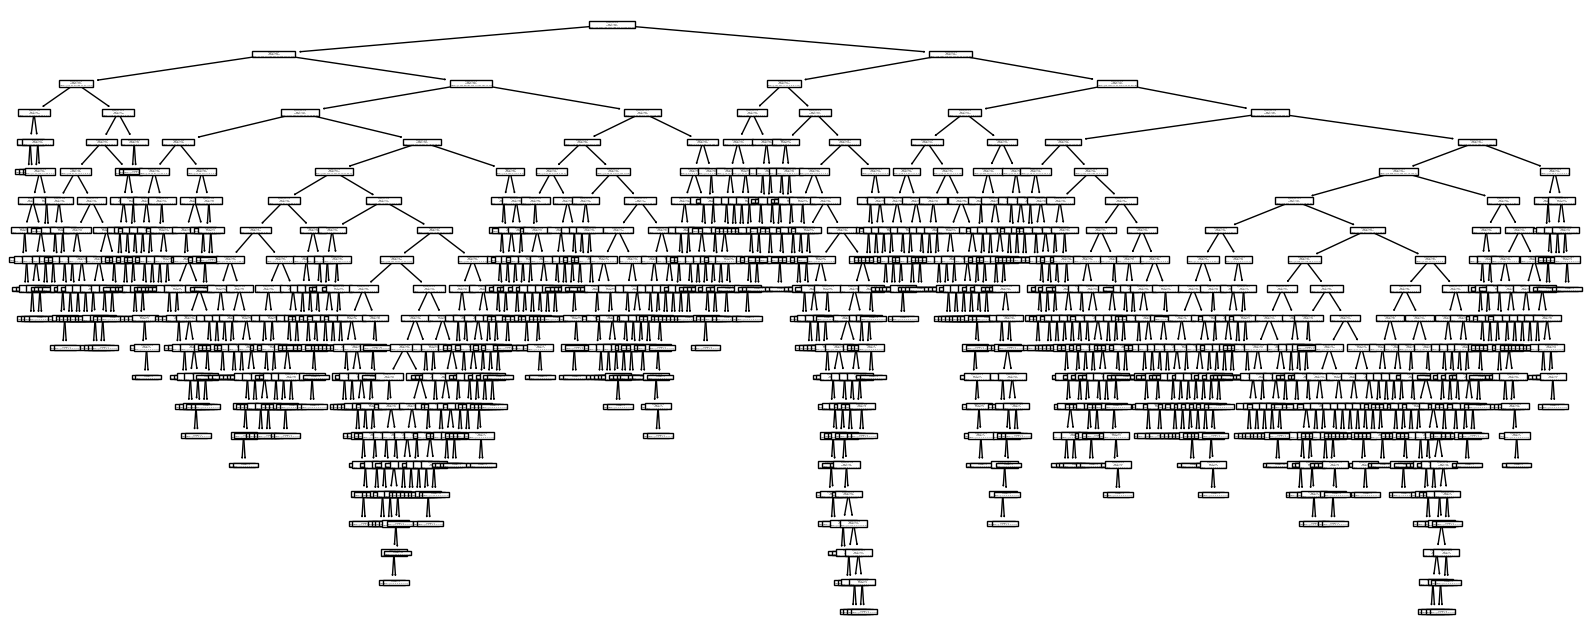

In [7]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 8))
plot_tree(dt_train)

#### 1.1) Evaluation on training dataset

In [8]:
from sklearn.metrics import classification_report

report_train = classification_report(y_train, predictions)

print(report_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       210
           1       1.00      1.00      1.00      2220
           2       1.00      1.00      1.00      2250
           3       1.00      1.00      1.00      1410
           4       1.00      1.00      1.00      1980
           5       1.00      1.00      1.00       210
           6       1.00      1.00      1.00       360
           7       1.00      1.00      1.00       240
           8       1.00      1.00      1.00       540
           9       1.00      1.00      1.00       270

    accuracy                           1.00      9690
   macro avg       1.00      1.00      1.00      9690
weighted avg       1.00      1.00      1.00      9690



In [9]:
from sklearn.metrics import accuracy_score

accuracy_train = accuracy_score(y_train, predictions)
print('Accuracy on training dataset = ', accuracy_train)

Accuracy on training dataset =  0.9991744066047472


In [10]:
from sklearn.metrics import confusion_matrix

confusion_matrix_train = confusion_matrix(y_train, predictions)
confusion_matrix_train

array([[ 209,    1,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 2217,    3,    0,    0,    0,    0,    0,    0,    0],
       [   0,    1, 2249,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    2, 1408,    0,    0,    0,    0,    0,    0],
       [   0,    1,    0,    0, 1979,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,  210,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,  360,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,  240,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,  540,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,  270]],
      dtype=int64)

<Axes: >

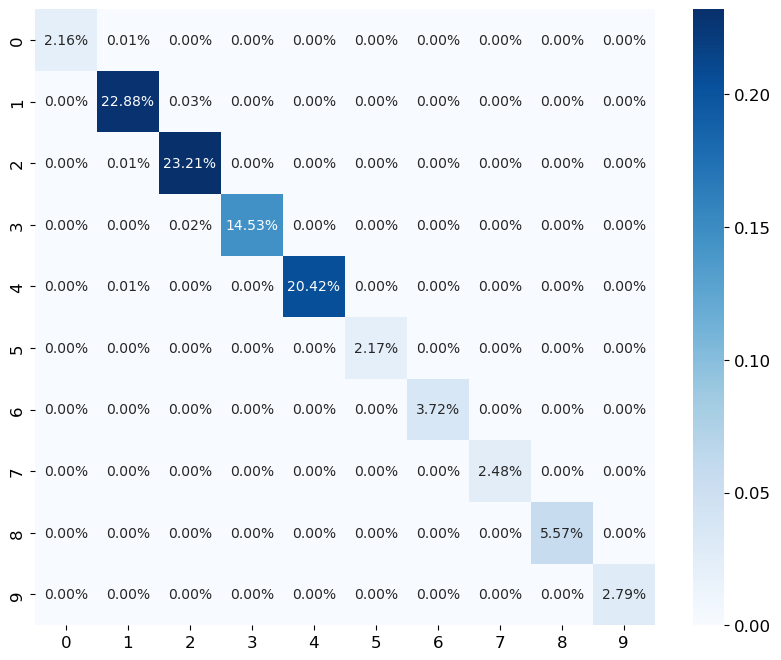

In [11]:
import seaborn as sns
plt.figure(figsize=(10, 8)) 
sns.heatmap(confusion_matrix_train/np.sum(confusion_matrix_train), annot=True,  fmt='.2%', cmap='Blues')

In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from sklearn.metrics import roc_auc_score

def calculate_metrics_and_mean_train(X_train, y_train, y_pred, model):
    report = classification_report(y_train, y_pred, output_dict=True,zero_division=0)
    report_df = pd.DataFrame(report).T.iloc[:-3].drop(columns='support')
    cm = confusion_matrix(y_train, y_pred)
    tp = np.diagonal(cm)
    fn = np.sum(cm, axis=1) - tp
    fp = np.sum(cm, axis=0) - tp
    tn = np.sum(cm) - (tp + fn + fp)
    tp_rate = tp / (tp + fn)
    fp_rate = fp / (fp + tn)
    tp_fp_rate_df = pd.DataFrame({'TPR': tp_rate, 'FPR': fp_rate}, index=range(len(tp_rate)))
    specificity = []
    unique_labels = np.unique(y_train)
    try:
        for i in range(len(unique_labels)):
            true_negative = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
            total_negative = np.sum(cm) - np.sum(cm[i, :])
            specificity.append(true_negative / total_negative)
        specificity_df = pd.DataFrame({'specificity': specificity}, index=unique_labels)
    except:
        specificity_df = pd.DataFrame({'specificity': np.nan}, index=unique_labels)
    try:
        sensitivity = recall_score(y_train, y_pred, average=None)
        sensitivity_df = pd.DataFrame({'sensitivity': sensitivity}, index=unique_labels)
    except:
        sensitivity_df = pd.DataFrame({'sensitivity': np.nan}, index=unique_labels)

    result_df = pd.concat([report_df.reset_index().drop(columns='index'),
                           tp_fp_rate_df.reset_index().drop(columns='index'),
                           specificity_df.reset_index().drop(columns='index'),
                           sensitivity_df.reset_index().drop(columns='index')], axis=1)
    
    try:
        auc = roc_auc_score(y_train, model.predict_proba(X_train), multi_class='ovr')
    except:
        auc = 0
    auc_df = pd.DataFrame({'AUC': auc}, index=unique_labels)

    result_df = pd.concat([result_df, auc_df], axis=1)
    mean_values = pd.DataFrame(result_df.mean()).transpose()
    mean_values.index = ['mean']
    result_df = pd.concat([result_df, mean_values])
    
    return result_df

In [13]:
calculate_metrics_and_mean_train(x_train, y_train, predictions, dt_train)

,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,AUC
0,1.000000,0.995238,0.997613,0.995238,0.000000,1.000000,0.995238,0.999978
1,0.998649,0.998649,0.998649,0.998649,0.000402,0.999598,0.998649,0.999978
2,0.997782,0.999556,0.998668,0.999556,0.000672,0.999328,0.999556,0.999978
3,1.000000,0.998582,0.999290,0.998582,0.000000,1.000000,0.998582,0.999978
4,1.000000,0.999495,0.999747,0.999495,0.000000,1.000000,0.999495,0.999978
5,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.999978
6,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.999978
7,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.999978
8,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.999978
9,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.999978


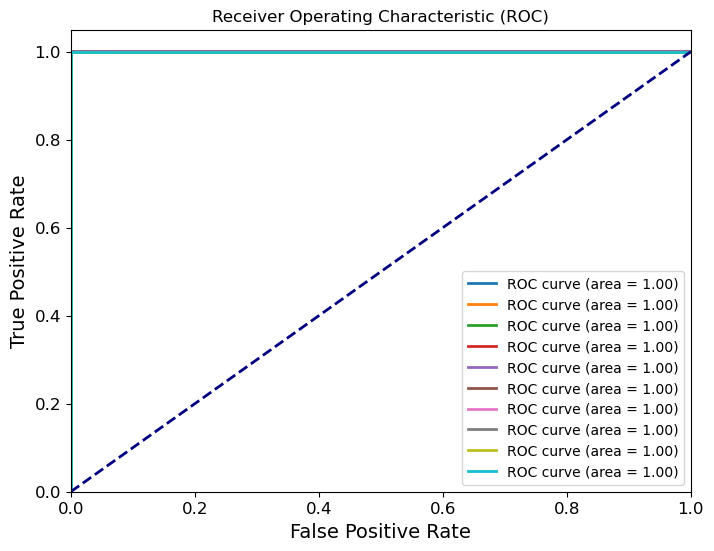

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

probabilities_dt_train = dt_train.predict_proba(x_train)
roc_auc_scores_dt_train = []

plt.figure(figsize=(8, 6))
unique_labels_dt_train = np.unique(y_train)

for i in range(len(unique_labels_dt_train)):
    fpr_dt_train, tpr_dt_train, _ = roc_curve((y_train == unique_labels_dt_train[i]).astype(int), probabilities_dt_train[:, i])
    roc_auc_dt_train = auc(fpr_dt_train, tpr_dt_train)
    roc_auc_scores_dt_train.append(roc_auc_dt_train)
    plt.plot(fpr_dt_train, tpr_dt_train, lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_dt_train))
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

#### 1.2) Cross Validation on train dataset

In [15]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [16]:
scores = cross_val_score(dt_train, x_train, y_train, scoring="accuracy", cv=10)
display_scores(scores)

Scores: [0.55830753 0.62951496 0.70897833 0.6749226  0.66666667 0.73581011
 0.61506708 0.70588235 0.66976264 0.70691434]
Mean: 0.6671826625386996
Standard deviation: 0.0505849678463146


In [17]:
scores = cross_val_score(dt_train, x_train, y_train, scoring="neg_mean_squared_error", cv=10)
dt_train_nmse_scores = np.sqrt(-scores)
display_scores(dt_train_nmse_scores)

Scores: [2.07670255 1.83897715 1.63646527 1.64244526 1.71829229 1.53191032
 1.81951354 1.59268192 1.84513977 1.54465689]
Mean: 1.7246784950697873
Standard deviation: 0.16188416495957927
